# Introduction
**Automatic Workflow for Flood Extraction using Machine Learning Method**

This notebook provides a simple, step-by-step guide for an automatic workflow to extract flood data. The workflow covers everything from data collection to using a Random Forest model for flood extraction, followed by a damage assessment step. The final results include predictions of flood areas and evaluations of the impacts on populations, agricultural lands, and urban areas. Overal workflow can be illustrated in the Figure below.

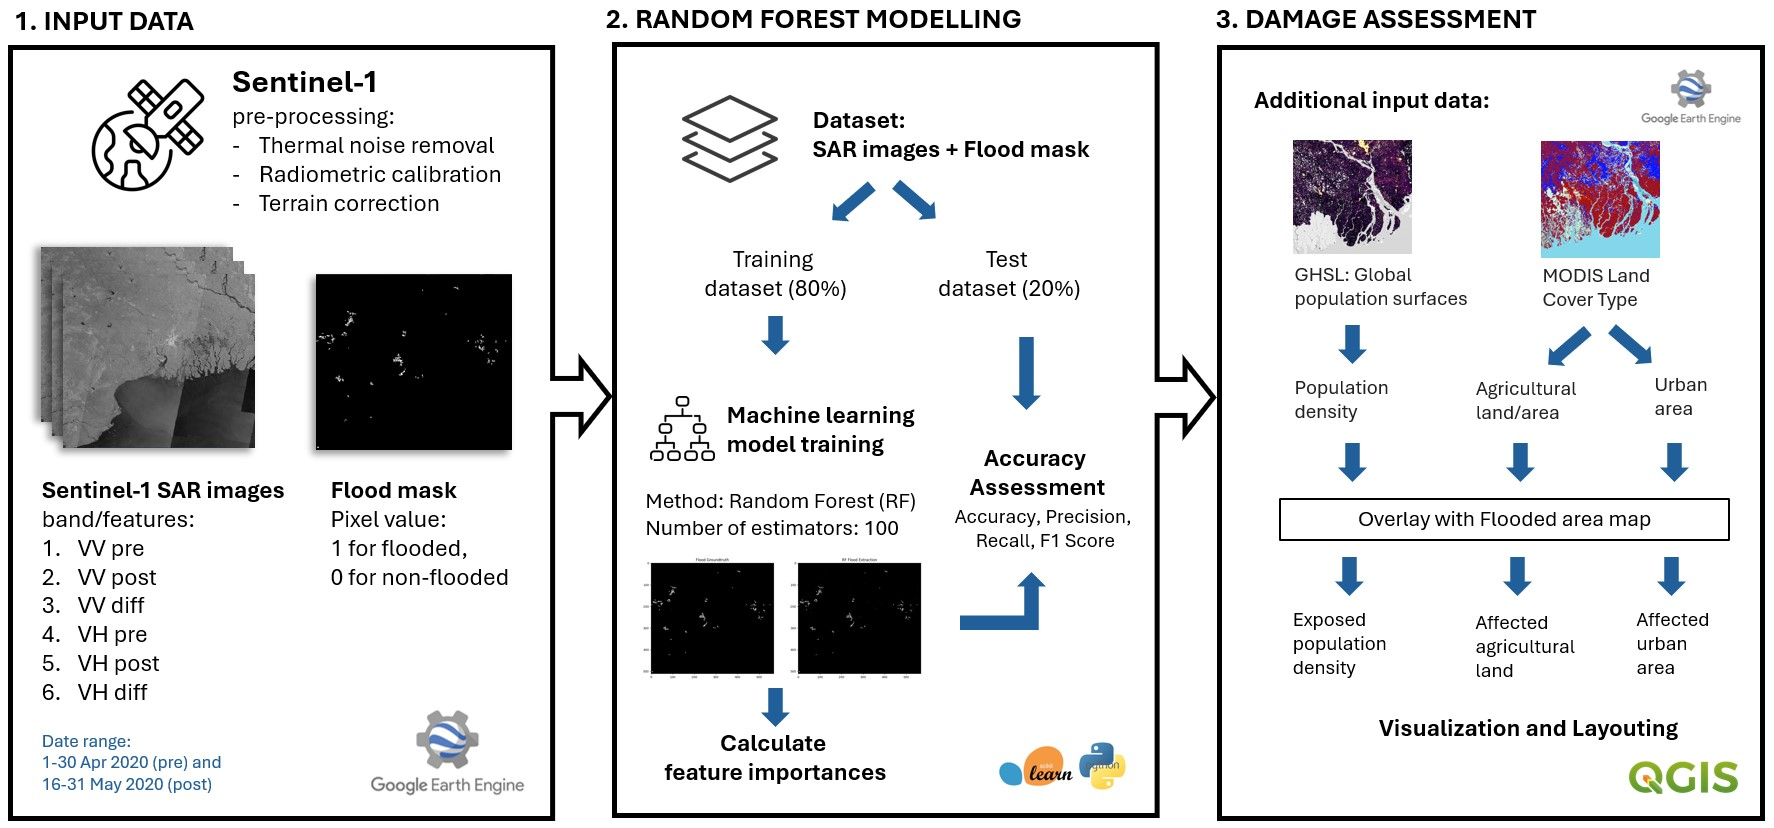

### Initialization

First, run the initialization step to connect the notebook to Google Earth Engine (GEE). We will be accessing data directly from GEE using the `geemap` library. This step ensures that the notebook is properly linked to GEE for data collection.

In [1]:
import ee
import geemap
import os

ee.Authenticate()
ee.Initialize(project='gee-project-432714') # change with your own GEE cloud project id name

### Study Case Definition

In this case, we focus on Cyclone Amphan, which occurred on May 20, 2020, affecting the Bengal region. This section defines the study area coordinates and the timeframe before and after the flood.

In [5]:
# Define the study area
bbox = [85.46745222177623, 24.331608064436086, 90.56510847177623, 19.77138363118683]
study_area = ee.Geometry.Rectangle(bbox)
aoi = ee.FeatureCollection(study_area)

# Set time parameters for BEFORE the flood.
before_start= '2020-04-01';
before_end= '2020-04-30';

# Now set the same parameters for AFTER the flood.
after_start= '2020-05-16';
after_end= '2020-05-31';

**Study Area Preview**
We can preview the study area by run the code block below.

In [ ]:
m = geemap.Map()
m.centerObject(geometry)
m.addLayer(geometry, {}, 'Study Area')
m

# Data Collection

In this section, we will outline the steps for data collection and preparation for flood extraction using a machine learning method. The data will primarily be sourced from the GEE platform, so a GEE account, which we initialized in the previous steps, is required.

In this workflow, we will use the Random Forest (RF) algorithm, a supervised learning model. To train the RF model, we need to prepare a collection of Sentinel-1 images as the training features and the corresponding flood mask as the ground truth.

### Training Image Features Collection

First, let's prepare the training image features. We will use SAR data from Sentinel-1, selecting two different polarization modes to represent conditions before and after the flood. The targeted output is to obtain an image collection with six bands, i.e. `VVpre, VVpost, VHpre, VHpost, VVdif, VHdif`. With pre is data before the flood, post is data after flood, and dif is the substract data before and after flood.

In [6]:
# Set SAR Parameters
pass_direction = 'DESCENDING'
difference_treshold = 1.25

# Polarization VV
# Load and filter Sentinel-1 GRD data by predefined parameters
collectionVV= ee.ImageCollection('COPERNICUS/S1_GRD') \
.filter(ee.Filter.eq('instrumentMode','IW')) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.eq('orbitProperties_pass',pass_direction)) \
.filter(ee.Filter.eq('resolution_meters',10)) \
.filterBounds(aoi) \
.select('VV')

# Polarization VH
# Load and filter Sentinel-1 GRD data by predefined parameters
collectionVH= ee.ImageCollection('COPERNICUS/S1_GRD') \
.filter(ee.Filter.eq('instrumentMode','IW')) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
.filter(ee.Filter.eq('orbitProperties_pass',pass_direction)) \
.filter(ee.Filter.eq('resolution_meters',10)) \
.filterBounds(aoi) \
.select('VH')

# Select images by predefined dates
before_collectionVV = collectionVV.filterDate(before_start, before_end)
after_collectionVV = collectionVV.filterDate(after_start,after_end)
before_collectionVH = collectionVH.filterDate(before_start, before_end)
after_collectionVH = collectionVH.filterDate(after_start,after_end)

# Create a mosaic of selected tiles and clip to study area
beforeVV = before_collectionVV.mosaic().clip(aoi)
afterVV = after_collectionVV.mosaic().clip(aoi)
beforeVH = before_collectionVH.mosaic().clip(aoi)
afterVH = after_collectionVH.mosaic().clip(aoi)

# Apply reduce the radar speckle by smoothing
smoothing_radius = 50
before_filteredVV = beforeVV.focal_mean(smoothing_radius, 'circle', 'meters')
after_filteredVV = afterVV.focal_mean(smoothing_radius, 'circle', 'meters')
before_filteredVH = beforeVH.focal_mean(smoothing_radius, 'circle', 'meters')
after_filteredVH = afterVH.focal_mean(smoothing_radius, 'circle', 'meters')

# Calculate the difference between before and after images
differenceVV = after_filteredVV.divide(before_filteredVV)
differenceVH = after_filteredVH.divide(before_filteredVH)

# COMBINE INTO SINGLE FILE
SARfeatures = ee.Image.cat(
before_filteredVV.rename('VVpre'),
after_filteredVV.rename('VVpost'),
before_filteredVH.rename('VHpre'),
after_filteredVH.rename('VHpost'),
differenceVV.rename('VVdiff'),
differenceVH.rename('VHdiff'))

# Export Sentinel-1 SAR features
geemap.ee_export_image_to_drive(
    image =SARfeatures,
    description='Sentinel_1_features',
    fileNamePrefix='SAR_features',
    region=aoi,
    maxPixels=1e10
    )

### Training Mask Collection

Along with image collection, we need training mask collection to train the RF model. Given the unavailability of field-surveyed ground-truth data, a simple thresholding approach using VV polarization from pre- and post-flood imagery is adopted as the mask layer/ground truth.

⚠⚠  This step assumes that the threshold methods accurately represent the actual flood conditions. However, for more reliable and realistic results, field-surveyed data is essential.  

In [10]:
# SET SAR PARAMETER
polarization = "VH"
pass_direction = "DESCENDING"
difference_threshold = 1.4 # threshold to be applied on the difference image (after flood - before flood). It has been chosen by trial and error.

# Load and filter Sentinel-1 GRD data by predefined parameters
collection= ee.ImageCollection('COPERNICUS/S1_GRD') \
.filter(ee.Filter.eq('instrumentMode','IW')) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization)) \
.filter(ee.Filter.eq('orbitProperties_pass',pass_direction)) \
.filter(ee.Filter.eq('resolution_meters',10)) \
.filterBounds(aoi) \
.select(polarization)

# Select images by predefined dates
before_collection = collection.filterDate(before_start, before_end)
after_collection = collection.filterDate(after_start,after_end)

# Create a mosaic of selected tiles and clip to study area
before = before_collection.mosaic().clip(aoi)
after = after_collection.mosaic().clip(aoi)

# Apply reduce the radar speckle by smoothing
smoothing_radius = 50
before_filtered = before.focal_mean(smoothing_radius, 'circle', 'meters')
after_filtered = after.focal_mean(smoothing_radius, 'circle', 'meters')

**Flood Extend Calculation**

In [11]:
# Calculate the difference between the before and after images
difference = after_filtered.divide(before_filtered)

# Apply the predefined difference-threshold and create the flood extent mask
threshold = difference_threshold
difference_binary = difference.gt(threshold)

# Refine flood result using additional datasets

# Include JRC layer on surface water seasonality to mask flood pixels from areas
# of "permanent" water (where there is water > 10 months of the year)
swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('seasonality')
swater_mask = swater.gte(10).updateMask(swater.gte(10))

#Flooded layer where perennial water bodies (water > 10 mo/yr) is assigned a 0 value
flooded_mask = difference_binary.where(swater_mask,0)
# final flooded area without pixels in perennial waterbodies
flooded = flooded_mask.updateMask(flooded_mask)

# Compute connectivity of pixels to eliminate those connected to 8 or fewer neighbours
# This operation reduces noise of the flood extent product
connections = flooded.connectedPixelCount()
flooded = flooded.updateMask(connections.gte(8))

# Mask out areas with more than 5 percent slope using a Digital Elevation Model
DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
terrain = ee.Algorithms.Terrain(DEM)
slope = terrain.select('slope')
flooded = flooded.updateMask(slope.lt(5))

# Calculate flood extent area
# Create a raster layer containing the area information of each pixel
flood_pixelarea = flooded.select(polarization) \
.multiply(ee.Image.pixelArea())

# Sum the areas of flooded pixels
# default is set to 'bestEffort: True' in order to reduce compuation time, for a more
# accurate result set bestEffort to False and increase 'maxPixels'.
flood_stats = flood_pixelarea.reduceRegion(
reducer=ee.Reducer.sum(),
geometry=aoi,
scale=10,
#maxPixels=1e9,
bestEffort=True
)

# Convert the flood extent to hectares (area calculations are originally given in meters)
flood_area_ha = flood_stats \
.getNumber(polarization) \
.divide(10000) \
.round()

print('Total flooded area:', flood_area_ha.getInfo(), 'ha')

Total flooded area: 65758 ha


In [ ]:
# Export Flood mask to Google Drive
geemap.ee_export_image_to_drive(
    image =flooded,
    description='flooded_mask',
    fileNamePrefix='flooded_mask',
    region=aoi,
    maxPixels=1e10
    )

**Display Training Mask**

In [13]:
m = geemap.Map()
m.centerObject(geometry,10)
m.addLayer(flooded,{'palette':"0000FF"},'Flooded Area')
m

Map(center=[22.058918366187005, 88.01628034677618], controls=(WidgetControl(options=['position', 'transparent_…

Alright! Now that we’ve successfully collected the dataset, it’s time to move on to building the machine learning model: the Random Forest!

# Random Forest Flood Extraction

We chose the Random Forest algorithm for this task because it performs well even with small datasets. Its use of random classifiers helps prevent overfitting, making the model more robust. In this project, we’ll train the Random Forest model to extract flood information using Sentinel-1 data. Let’s dive in!

In [15]:
# Run this code to install rasterio (if needed)
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.3 MB/s eta 0:00:00


In [16]:
import numpy as np
import cv2
import rasterio
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

Run this code to mount Google Drive folder. We need to mount this Google Colab notebook to our Google Drive folder to access the dataset we prepared earlier.

In [17]:
# Mount to access Google Drive Folders
from google.colab import drive
drive.mount("/content/gdrive")

# Define working directory
%cd '/content/gdrive/MyDrive/Project - RWTH' # Set the directory path where we save the dataset

Mounted at /content/gdrive
/content/gdrive/MyDrive/Project - RWTH


### Import Dataset

Now let's import the dataset that we prepared erlier, both image features collections and the corresponding flood masks.

In [21]:
# Path to the image file
image_path = 'Train_images/SAR_features.tif'

# Initialize MinMaxScaler for normalization
scaler = MinMaxScaler()

# Open the image and read the bands
with rasterio.open(image_path) as src:
    VVpre = src.read(1)
    VVpost = src.read(2)
    VHpre = src.read(3)
    VHpost = src.read(4)
    VVdiff = src.read(5)
    VHdiff = src.read(6)

# Create a DataFrame for the image data
img_df = pd.DataFrame()

# Normalize each band and add to the DataFrame
bands = {
    'VVpre': VVpre,
    'VVpost': VVpost,
    'VHpre': VHpre,
    'VHpost': VHpost,
    'VVdiff': VVdiff,
    'VHdiff': VHdiff
}

for band_name, band_data in bands.items():
    # Flatten the band and normalize
    band_flat = band_data.flatten().reshape(-1, 1)
    band_normalized = scaler.fit_transform(band_flat).flatten()

    # Add the normalized band to the DataFrame
    img_df[band_name] = band_normalized

print(f"Image DataFrame shape: {img_df.shape}")

# Import Mask
mask_path = 'Train_masks/flooded.tif'

mask_df = pd.DataFrame()
with rasterio.open(mask_path) as src:
  mask = src.read(1)
  mask_df['mask_label'] = mask.flatten()

print(f"Mask DataFrame shape: {mask_df.shape}")

Image DataFrame shape: (290248, 6)
Mask DataFrame shape: (290248, 1)


In [20]:
# Split Training and Test Dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(img_df, mask_df, test_size=0.2, random_state=42)

# Print dataset shapes to verify
print("Training set shape (x_train, y_train):", x_train.shape, y_train.shape)
print("Test set shape (x_test, y_test):", x_test.shape, y_test.shape)

Training set shape (x_train, y_train): (232198, 6) (232198, 1)
Test set shape (x_test, y_test): (58050, 6) (58050, 1)


### Random Forest Training

All set! Now let run

In [22]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100, # we can experiment with the number of estimators
    random_state=42,
    oob_score=True)
model.fit(x_train, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [23]:
# Calculate feature importances
feature_list = list(x_train.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

VVdiff    0.293599
VVpost    0.148890
VHdiff    0.148272
VHpost    0.145314
VVpre     0.141338
VHpre     0.122586
dtype: float64


💡 It's clear that VVdiff has the highest feature importance value since the ground truth mask layer was generated from VVdiff. This highlights the importance of having high-quality training data for accurate results.

### Testing and Accuracy Check

In [24]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(x_test)

# Check accuracy on test dataset.
print("Accuracy = ", accuracy_score(y_test, y_pred))
# Print Classification Report
print(classification_report(y_test, y_pred))

Accuracy =  0.9950387596899225
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57752
           1       0.53      0.30      0.38       298

    accuracy                           1.00     58050
   macro avg       0.76      0.65      0.69     58050
weighted avg       0.99      1.00      0.99     58050



💡 The accuracy assessment of the random forest model demonstrated an exceptional overall accuracy of 0.995. However, an analysis of the precision, recall, and F1-score for individual classes reveals that the model performs poorly in classifying flood pixels. This limitation arises due to an imbalance in the number of flood and non-flood pixels (support) used during training. To enhance the model’s performance, it is recommended to create a more balanced composition of flood and non-flood classes in the training dataset.

In [25]:
# Save the model
model_name = 'rf_flood_model'
pickle.dump(model, open(model_name, 'wb'))

In [26]:
# Load and run prediction using trained model
loaded_model = pickle.load(open(model_name, 'rb'))
prediction = loaded_model.predict(img_df)
print(prediction.shape)
predict_full = prediction.reshape(mask.shape)
print(predict_full.shape)

(290248,)
(511, 568)


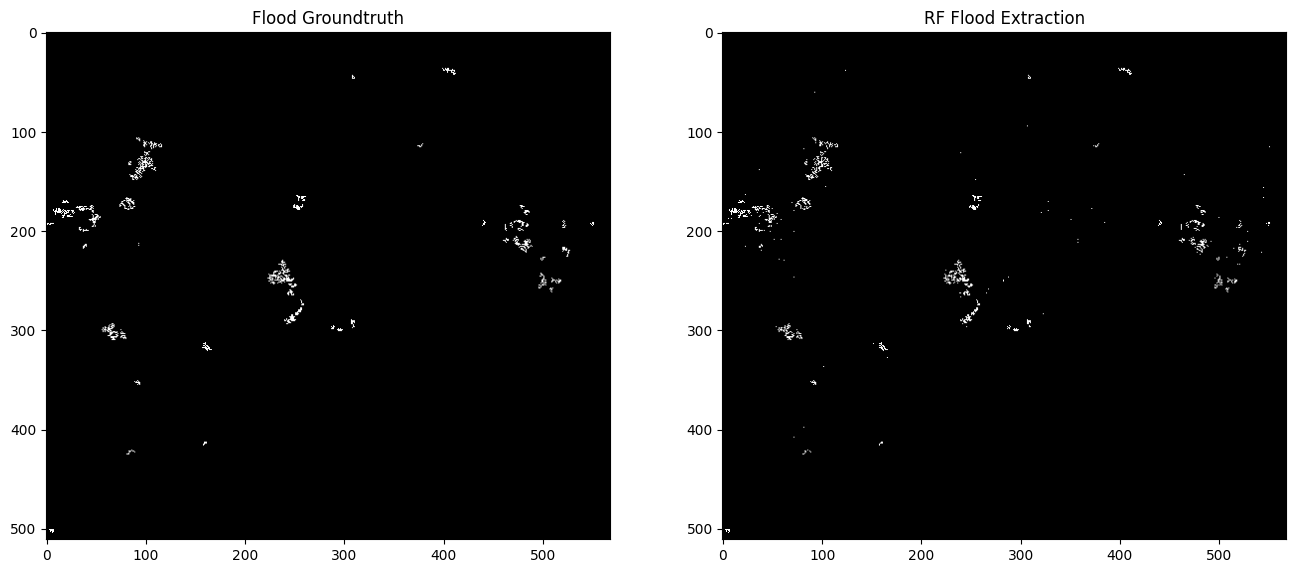

In [27]:
# Preview comparison between Groundtruth and Prediction
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].imshow(mask, cmap='gray')
axs[0].set_title('Flood Groundtruth')
axs[1].imshow(predict_full, cmap='gray')
axs[1].set_title('RF Flood Extraction')
plt.show()

Despite its limitations, visual inspection of the results indicates that the model provides reasonably accurate flood predictions, closely aligning with the ground truth.

Now, let's do damage assessment!

# Flood Damage Assessment

**Exposed Population Density**

👪 The first step in damage assessment is calculating the population density exposed to the detected flood.

In [29]:
# Load JRC Global Human Settlement Popluation Density layer
# Resolution: 250. Number of people per cell is given.
population_count = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015').clip(aoi)

# Calculate the amount of exposed population
# get GHSL projection
GHSLprojection = population_count.projection()

# Reproject flood layer to GHSL scale
flooded_res1 = flooded \
.reproject(
crs=GHSLprojection
)

# Create a raster showing exposed population only using the resampled flood layer
population_exposed = population_count \
.updateMask(flooded_res1) \
.updateMask(population_count)

#Sum pixel values of exposed population raster
stats = population_exposed.reduceRegion(
reducer=ee.Reducer.sum(),
geometry=aoi,
scale=250,
maxPixels =1e9
)

# get number of exposed people as integer
number_pp_exposed = stats.getNumber('population_count').round()
print('Number of people exposed by flood:', number_pp_exposed.getInfo())

Number of people exposed by flood: 296612


**Affected Crop Land**

In [30]:
# using MODIS Land Cover Type Yearly Global 500m
# filter image collection by the most up-to-date MODIS Land Cover product
LC = ee.ImageCollection('MODIS/061/MCD12Q1') \
.filterDate('2014-01-01',after_end) \
.sort('system:index',False) \
.select("LC_Type1") \
.first() \
.clip(aoi)

# Extract only cropland pixels using the classes cropland (>60%) and Cropland/Natural
# Vegetation Mosaics: mosaics of small-scale cultivation 40-60% incl. natural vegetation
cropmask = LC \
.eq(12) \
.Or(LC.eq(14))
cropland = LC \
.updateMask(cropmask)

# get MODIS projection
MODISprojection = LC.projection()

# Reproject flood layer to MODIS scale
flooded_res = flooded \
.reproject(
crs=MODISprojection
)

# Calculate affected cropland using the resampled flood layer
cropland_affected = flooded_res \
.updateMask(cropland)

# get pixel area of affected cropland layer
crop_pixelarea = cropland_affected \
.multiply(ee.Image.pixelArea());

# sum pixels of affected cropland layer
crop_stats = crop_pixelarea.reduceRegion(
reducer=ee.Reducer.sum(),
geometry=aoi,
scale=500,
maxPixels=1e9
)

# convert area to hectares
crop_area_ha = crop_stats \
.getNumber(polarization) \
.divide(10000) \
.round()

print('Total affected cropland area:', crop_area_ha.getInfo(), 'ha')

Total affected cropland area: 14039 ha


**Affected Urban Area**

In [32]:
# Using the same MODIS Land Cover Product
# Filter urban areas
urbanmask = LC.eq(13)
urban = LC \
.updateMask(urbanmask)

#Calculate affected urban areas using the resampled flood layer
urban_affected = urban \
.mask(flooded_res) \
.updateMask(urban)

# get pixel area of affected urban layer
urban_pixelarea = urban_affected \
.multiply(ee.Image.pixelArea());

# sum pixels of affected cropland layer
urban_stats = urban_pixelarea.reduceRegion(
reducer=ee.Reducer.sum(),
geometry=aoi,
scale=500,
bestEffort=True,
)

# convert area to hectares
urban_area_ha = urban_stats \
.getNumber('LC_Type1') \
.divide(10000) \
.round()

print('Total affected urban area:', urban_area_ha.getInfo(), 'ha')

Total affected urban area: 0 ha


**Visualization**

In [35]:
Map = geemap.Map()
# Map.add_basemap('SATELLITE')

# Before and after flood SAR mosaic
Map.centerObject(aoi,10)
Map.addLayer(before_filtered, {'min':-25, 'max':0}, 'Before Flood',1)
Map.addLayer(after_filtered, {'min':-25, 'max':0}, 'After Flood',1)

# Difference layer
Map.addLayer(difference,{'min':0, 'max':2},"Difference Layer",0)

# Flooded areas
Map.addLayer(flooded,{'palette':"0000FF"},'Flooded areas')

# Population Density
populationCountVis = {
    'min': 0,
    'max': 200.0,
    'palette': ['060606','337663','337663','ffffff'],
}
Map.addLayer(population_count, populationCountVis, 'Population Density',0)

# Exposed Population
populationExposedVis = {
    'min': 0,
    'max': 200.0,
    'palette': ['yellow', 'orange', 'red'],
}
Map.addLayer(population_exposed, populationExposedVis, 'Exposed Population')

# MODIS Land Cover
LCVis = {
    'min': 1.0,
    'max': 17.0,
    'palette': [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff'
    ],
}
Map.addLayer(LC, LCVis, 'Land Cover',0)

# Cropland
croplandVis = {
    'min': 0,
    'max': 14.0,
    'palette': ['30b21c'],
}
Map.addLayer(cropland, croplandVis, 'Cropland',0)

# Affected cropland
Map.addLayer(cropland_affected, croplandVis, 'Affected Cropland')

# Urban
urbanVis = {
    'min': 0,
    'max': 13.0,
    'palette': ['grey'],
}
Map.addLayer(urban, urbanVis, 'Urban',0)

# Affected urban
Map.addLayer(urban_affected, urbanVis, 'Affected Urban')

# Add Legend
from ipyleaflet import LegendControl
legend = LegendControl({'potentially flooded areas':'#0000FF', 'affected cropland':'#30b21c', 'affected urban':'grey'}, name="Legend", position="bottomright")
Map.add_control(legend)
Map

Map(center=[22.058918366187005, 88.01628034677618], controls=(WidgetControl(options=['position', 'transparent_…

That's all! We are successed to do end-to-end automatic flood extraction using machine learning method.

This code was prepared by Ali Surojaya (alisurajaya@gmail.com), with reference sources:

1. [UN Spider Knowledge Portal](https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-google-earth-engine-flood-mapping/step-by-step)
2. [GEE Map by Dr. Quisheng Wu](https://geemap.org/tutorials/)
3. [Python for Microscopist](https://github.com/bnsreenu/python_for_microscopists/blob/master/060-RandomForest1.py)